# Types of Face Masks Notebook

Importing the required libraries

In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D
from tensorflow.keras.layers import Input,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.callbacks import EarlyStopping

Loading and Preprocessing of the dataset

In [27]:
import os
from collections import defaultdict

# Generate a label-to-integer dictionary
def create_label_dict(train_path):
    label_names = os.listdir(train_path)  # Assumes directories in the given path are the labels
    return dict(zip(label_names, range(len(label_names))))

# Count the number of images for each label
def count_images_per_label(train_path):
    counts = defaultdict(int)
    label_dict = create_label_dict(train_path)
    for label in label_dict.keys():
        label_path = os.path.join(train_path, label)
        counts[label] = len(os.listdir(label_path))  # Count files in each label folder
    return counts

# Specify your train dataset path
train_path = '/kaggle/input/face-mask-types-dataset/Dataset/train'

# Get label dictionary
dict_labels = create_label_dict(train_path)
print(f"Label Dictionary: {dict_labels}")

# Get image counts
image_counts = count_images_per_label(train_path)
print("\nImage Counts per Label:")
for label, count in image_counts.items():
    print(f"{label}: {count}")


Label Dictionary: {'n95': 0, 'n95v': 1, 'srg': 2, 'cloth': 3, 'nfm': 4}

Image Counts per Label:
n95: 354
n95v: 390
srg: 342
cloth: 396
nfm: 474


In [28]:
# Function to load the dataset
def load_dataset(path, label_dict):
    images, labels = [], []
    for folder in os.listdir(path):
        # Check if folder is a valid label
        if folder in label_dict:
            label = label_dict[folder]
            folder_path = os.path.join(path, folder)

            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                
                # Read, preprocess, and resize the image
                try:
                    image = cv2.imread(file_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
                    image = cv2.resize(image, (224, 224))  # Resize to 224x224
                    images.append(image)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

    images = np.array(images, dtype='float32') / 255.0  # Normalize images
    labels = np.array(labels)  # Labels as integers
    return images, labels

# Load the train dataset
train_images, train_labels = load_dataset('/kaggle/input/face-mask-types-dataset/Dataset/train', dict_labels)

# Shuffle the dataset
train_images, train_labels = shuffle(train_images, train_labels)

print(f"Dataset loaded with {train_images.shape[0]} images and {len(set(train_labels))} unique labels.")

Dataset loaded with 1956 images and 5 unique labels.


In [29]:
train_images.shape

(1956, 224, 224, 3)

In [30]:
train_labels.shape

(1956,)

Distribution of the dataset

In [ ]:
import matplotlib.pyplot as plt

# Displaying 10 random images in a 5x5 grid with their respective labels
plt.figure(figsize=(10, 10))

for i in range(10):  # Displaying 10 images
    plt.subplot(5, 5, i + 1)  # Create a 5x5 grid
    plt.imshow(images[i])  # Show image
    plt.axis('off')  # Hide axis to avoid clutter
    plt.xlabel(label_names[labels[i]])  # Label each image with its class name
    plt.grid(False)  # Remove the grid
    
# Tidy up the layout to avoid overlapping labels
plt.tight_layout()
plt.show()

print("Displaying 10 random images with their labels.")


Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224,224)
batch_size = 32

# Improved ImageDataGenerator with diverse augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values between 0 and 1
    rotation_range=45,  # Increased rotation range for robustness
    width_shift_range=0.3,  # Broadened width shift for more variation
    height_shift_range=0.3,  # Broadened height shift for more variation
    shear_range=0.25,  # Slightly increased shear for diversity
    zoom_range=[0.7, 1.3],  # Allows both zoom-in and zoom-out
    horizontal_flip=True,  # Randomly flips images horizontally
    vertical_flip=False,  # Disabled to maintain natural orientation
    brightness_range=[0.8, 1.2],  # Slight brightness variations
    fill_mode='reflect',  # Use 'reflect' for smoother boundary handling
    validation_split=0.15  # Maintain 15% validation split
)


# Flow training data with subset='training' for training set
train_ds = train_datagen.flow_from_directory(
    '/kaggle/input/face-mask-types-dataset/Dataset/train',  # Directory for training data
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # This will use 85% of the images from the training set
    color_mode="rgb"
)

# Flow validation data with subset='validation' for validation set (from the test data)
val_ds = train_datagen.flow_from_directory(
    '/kaggle/input/face-mask-types-dataset/Dataset/train',  # Directory for validation data
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # This will use 10% of the test data as the validation set
    color_mode="rgb"
)

# Separate test data (no augmentation) from the test directory
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling, no augmentation

test_ds = test_datagen.flow_from_directory(
    '/kaggle/input/face-mask-types-dataset/Dataset/test',  # Directory for test data
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode="rgb"
)

print("Training, validation, and test data loaded successfully.")



In [ ]:
# Check label counts in training dataset
print("Training labels count:", len(train_ds.class_indices))
print("Training data batches:", len(train_ds))

# Check label counts in validation dataset
print("Validation labels count:", len(val_ds.class_indices))
print("Validation data batches:", len(val_ds))

# Check label counts in test dataset
print("Test labels count:", len(test_ds.class_indices))
print("Test data batches:", len(test_ds))


In [ ]:
import numpy as np

# Count labels in training dataset
train_labels = train_ds.labels
train_label_counts = dict(zip(*np.unique(train_labels, return_counts=True)))
print("Training dataset label counts:", train_label_counts)

# Count labels in validation dataset
val_labels = val_ds.labels
val_label_counts = dict(zip(*np.unique(val_labels, return_counts=True)))
print("Validation dataset label counts:", val_label_counts)

# Count labels in test dataset
test_labels = test_ds.labels
test_label_counts = dict(zip(*np.unique(test_labels, return_counts=True)))
print("Test dataset label counts:", test_label_counts)


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights based on training labels
train_labels = train_ds.labels
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)

# Create a dictionary mapping class indices to their weights
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))

# Print class weights for better understanding
print("Class weights for the training dataset:", class_weight_dict)


In [ ]:
import numpy as np
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil

# Step 1: Extract file paths and labels from train_ds
train_filepaths = train_ds.filepaths
train_labels = train_ds.labels

# Step 2: Get class counts and find the minimum class size
class_counts = np.bincount(train_labels)
min_class_size = min(class_counts)

# Step 3: Create directories for balanced dataset
balanced_dir = '/kaggle/working/balanced_train_data'
os.makedirs(balanced_dir, exist_ok=True)

# Create subdirectories for each class
for i in range(len(class_counts)):
    os.makedirs(os.path.join(balanced_dir, str(i)), exist_ok=True)

# Step 4: Under-sample the majority classes
balanced_filepaths = []
balanced_labels = []

for class_index in range(len(class_counts)):
    # Get the indices of the images for the current class
    class_indices = np.where(train_labels == class_index)[0]
    
    # Sample the data to the minimum class size (under-sampling)
    sampled_indices = resample(class_indices, n_samples=min_class_size, random_state=42)
    
    # Copy the sampled images to the new balanced directory
    for idx in sampled_indices:
        file_path = train_filepaths[idx]
        file_name = os.path.basename(file_path)
        class_folder = os.path.join(balanced_dir, str(class_index), file_name)
        shutil.copy(file_path, class_folder)  # Copy file to new directory
        
        # Append the file paths and labels to the balanced lists
        balanced_filepaths.append(file_path)
        balanced_labels.append(class_index)

# Step 5: Create a new ImageDataGenerator for the balanced dataset
balanced_datagen = ImageDataGenerator(rescale=1./255)

balanced_train_ds = balanced_datagen.flow_from_directory(
    balanced_dir,  # Path to the new balanced directory
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode="rgb"
)

# Step 6: Print the label counts for the new balanced dataset
balanced_labels = np.array(balanced_labels)
balanced_class_counts = dict(zip(*np.unique(balanced_labels, return_counts=True)))

print("Balanced training dataset label counts:", balanced_class_counts)


In [ ]:
# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

# Loop through the first 5 images from the training data
for i in range(5):
    image, label = next(train_ds)
    
    # Select the first image in the batch
    img = image[0]
    
    # Remove color axis if necessary
    img = np.squeeze(img)
    
    # Plot the image
    ax[i].imshow(img)
    
    # Remove axis ticks for a cleaner look
    ax[i].axis('off')
    
    # Set the title as the label (class name)
    ax[i].set_title(label_names[np.argmax(label[0])], fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


Transfer Learning ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model

# Define input shape
inputs = Input(shape=(224, 224, 3))

# Load base model (ResNet50V2) without weights (we'll add weights manually)
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,  # Exclude the top classification layers
    weights=None,  # Do not load default weights
    input_tensor=inputs,  # Use the defined input shape
    pooling='avg'  # Use global average pooling
)

# Path to the .h5 weights file
weights_path = '/kaggle/input/resnet-50-v2/tensorflow2/default/1/resnet50v2_weights_tf_dim_ordering_tf_kernels.h5'
# Load the weights into the base model by matching layer names
base_model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("ResNet50V2 weights partially loaded (matched layers only).")

# Add custom layers to the model
x = layers.Dense(128, activation='relu')(base_model.output)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax')(x)

# Create the complete model
mob_model = Model(inputs=base_model.input, outputs=outputs)

# Display model summary
mob_model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
mob_model.compile(
    optimizer = Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='AUC'),
        'accuracy'  # Use 'accuracy' as a string, not inside another list
    ]
)


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Step 1: Get the labels from the training dataset
train_labels = train_ds.labels  # Assuming 'train_ds' is an instance of 'flow_from_directory'

# Step 2: Compute class weights using sklearn utility with more refined inverse frequency strategy
class_counts = np.bincount(train_labels)  # Count occurrences of each class in the labels
total_samples = len(train_labels)  # Total number of samples
num_classes = len(np.unique(train_labels))  # Total number of classes

# Calculate class weights inversely proportional to class frequencies
class_weights = {i: (total_samples / (class_counts[i] * num_classes)) for i in range(num_classes)}

# Step 3: Optionally apply further scaling to adjust class weight distribution
scaling_factor = 1.5 #Scale the class weights by a factor to adjust further if needed

# Apply scaling if necessary (optional)
class_weights = {k: v * scaling_factor for k, v in class_weights.items()}

# Print the computed class weights
print("Improved Class Weights: ", class_weights)


In [ ]:
# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop after 5 epochs without improvement
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6
)


# Train the model with callbacks (without custom logging)
history = mob_model.fit(
    train_ds,  # Pass train_ds directly
    epochs=15,  # Train for more epochs
    batch_size=16,
    class_weight=class_weights,
    validation_data=val_ds,  # Pass val_ds directly  # Include class weights if defined
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1# Remove custom logging callback # Set verbosity to 1 (Progress bar with metrics)
)



In [ ]:
# Evaluate the model on the test dataset to get loss, accuracy, and AUC
test_results = mob_model.evaluate(test_ds, verbose=1)

# Assuming the model was compiled with 'accuracy' and 'AUC' metrics
test_loss = test_results[0]
test_accuracy = test_results[2]
test_auc = test_results[1]

# Print test results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")


Accuracy Graphs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Plot Accuracy with Highlighted Max and Min
plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility
plt.plot(history.history['accuracy'], color='blue', linestyle='-', marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', linestyle='-', marker='x', label='Validation Accuracy')

# Find the highest and lowest accuracy
max_accuracy = np.max(history.history['accuracy'])
min_accuracy = np.min(history.history['accuracy'])

# Add markers for highest and lowest accuracy
max_accuracy_epoch = np.argmax(history.history['accuracy'])
min_accuracy_epoch = np.argmin(history.history['accuracy'])
plt.scatter(max_accuracy_epoch, max_accuracy, color='green', label=f'Max Accuracy: {max_accuracy:.4f} at Epoch {max_accuracy_epoch + 1}', zorder=5)
plt.scatter(min_accuracy_epoch, min_accuracy, color='red', label=f'Min Accuracy: {min_accuracy:.4f} at Epoch {min_accuracy_epoch + 1}', zorder=5)

# Title and labels with enhanced font size
plt.title('Model Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Add gridlines for better readability
plt.grid(True)

# Customizing the legend and placing it at a better position
plt.legend(loc='lower right', fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Plot Loss with Highlighted Min and Max
plt.figure(figsize=(10, 6))  # Same figure size for consistency
plt.plot(history.history['loss'], color='red', linestyle='-', marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], color='green', linestyle='-', marker='x', label='Validation Loss')

# Find the highest and lowest loss
max_loss = np.max(history.history['loss'])
min_loss = np.min(history.history['loss'])

# Add markers for highest and lowest loss
max_loss_epoch = np.argmax(history.history['loss'])
min_loss_epoch = np.argmin(history.history['loss'])
plt.scatter(max_loss_epoch, max_loss, color='purple', label=f'Max Loss: {max_loss:.4f} at Epoch {max_loss_epoch + 1}', zorder=5)
plt.scatter(min_loss_epoch, min_loss, color='yellow', label=f'Min Loss: {min_loss:.4f} at Epoch {min_loss_epoch + 1}', zorder=5)

# Title and labels with enhanced font size
plt.title('Model Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add gridlines for better readability
plt.grid(True)

# Customizing the legend and placing it at a better position
plt.legend(loc='upper right', fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


Defining a predictor function to test the model

In [43]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nSpecies: {1}'.format(clas, name))

The given image is of 
Class: 1 
Species: n95


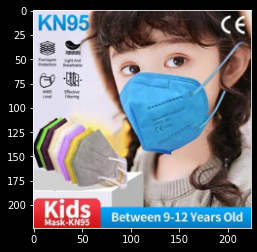

In [45]:
predictor('/kaggle/input/face-mask-types-dataset/Dataset/test/n95/355.jpg', model_fine)

Saving the model

In [ ]:
modelSaved = keras.models.load_model('Face_Mask_Detection.h5') 

# Fine Tuning The Trained Model More 

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define labels and their counts
labels = ['n95', 'n95v', 'srg', 'cloth', 'nfm']
label_counts = [354, 390, 342, 396, 474]  # Image counts per label
total_images = sum(label_counts)

# Calculate weights using sklearn
classes = np.array([0, 1, 2, 3, 4])  # Map labels to their indices
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=np.repeat(classes, label_counts)
)

# Convert weights to dictionary format for Keras
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"Computed Class Weights: {class_weights_dict}")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224,224)
batch_size = 32

# Improved ImageDataGenerator with diverse augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values between 0 and 1
    rotation_range=45,  # Increased rotation range for robustness
    width_shift_range=0.3,  # Broadened width shift for more variation
    height_shift_range=0.3,  # Broadened height shift for more variation
    shear_range=0.25,  # Slightly increased shear for diversity
    zoom_range=[0.7, 1.3],  # Allows both zoom-in and zoom-out
    horizontal_flip=True,  # Randomly flips images horizontally
    vertical_flip=False,  # Disabled to maintain natural orientation
    brightness_range=[0.8, 1.2],  # Slight brightness variations
    fill_mode='reflect',  # Use 'reflect' for smoother boundary handling
    validation_split=0.20  # Maintain 15% validation split
)


# Flow training data with subset='training' for training set
train_ds = train_datagen.flow_from_directory(
    '/kaggle/input/face-mask-types-dataset/Dataset/train',  # Directory for training data
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training', 
    shuffle = True,# This will use 85% of the images from the training set
    color_mode="rgb"
)

# Flow validation data with subset='validation' for validation set (from the test data)
val_ds = train_datagen.flow_from_directory(
    '/kaggle/input/face-mask-types-dataset/Dataset/train',  # Directory for validation data
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # This will use 10% of the test data as the validation set
    color_mode="rgb"
)

# Separate test data (no augmentation) from the test directory
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling, no augmentation

test_ds = test_datagen.flow_from_directory(
    '/kaggle/input/face-mask-types-dataset/Dataset/test',  # Directory for test data
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode="rgb"
)

print("Training, validation, and test data loaded successfully.")



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Compile the model with F1 score and AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow_addons.metrics import F1Score
# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop after 5 epochs without improvement
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'tuned_mask_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Reduce LR
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Step 1: Get the labels from the training dataset
train_labels = train_ds.labels  # Assuming 'train_ds' is an instance of 'flow_from_directory'

# Step 2: Compute class weights using sklearn utility with more refined inverse frequency strategy
class_counts = np.bincount(train_labels)  # Count occurrences of each class in the labels
total_samples = len(train_labels)  # Total number of samples
num_classes = len(np.unique(train_labels))  # Total number of classes

# Calculate class weights inversely proportional to class frequencies
class_weights = {i: (total_samples / (class_counts[i] * num_classes)) for i in range(num_classes)}

# Step 3: Optionally apply further scaling to adjust class weight distribution
scaling_factor = 1.5 #Scale the class weights by a factor to adjust further if needed

# Apply scaling if necessary (optional)
class_weights = {k: v * scaling_factor for k, v in class_weights.items()}

# Print the computed class weights
print("Improved Class Weights: ", class_weights)


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
saved_model_path = '/kaggle/input/mask_model/tensorflow2/default/1/model_mask.h5'  # Path to your saved model file
model_fine = load_model(saved_model_path, custom_objects={'F1Score': F1Score})

# Unfreeze base model layers for fine-tuning
for layer in model_fine.layers:
    layer.trainable = True  # Unfreeze all layers
    # Optional: Fine-tune selectively (e.g., specific layers only)
    # if "conv5" in layer.name:
    #     layer.trainable = True

# Compile the model again with a lower learning rate for fine-tuning
from tensorflow.keras.optimizers import Adam
model_fine.compile(
    optimizer=Adam(learning_rate=1e-5),  # Reduced learning rate
    loss='categorical_crossentropy',
    metrics=[
        AUC(name='AUC'),
        F1Score(num_classes=5, average='macro', name='F1-Score'),
        'accuracy'
    ]
)


In [ ]:
# Fine-tune the model
fine_tune_history = model_fine.fit(
    train_ds,  # Training dataset
    epochs=10,  # Additional fine-tuning epochs
    batch_size=32,  # Keep consistent batch size
    validation_data=val_ds,  # Validation dataset
    class_weight=class_weights,  # Use the computed class weights
    callbacks=[early_stopping, model_checkpoint, reduce_lr],  # Same callbacks
    verbose=1
)



In [34]:
# Evaluate the model on the test dataset
test_loss, test_auc, test_accuracy, test_f1_score = model_fine.evaluate(
    test_ds,  # Test dataset
    batch_size=16,  # Batch size used for testing
    verbose=1  # Print the evaluation progress
)

# Print the results
print("\nTest Evaluation Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")


11/11 [==============================] - 26s 2s/step - loss: 0.2858 - AUC: 0.9902 - F1-Score: 0.9063 - accuracy: 0.9152

Test Evaluation Results:
Test Loss: 0.2858
Test AUC: 0.9902
Test Accuracy: 0.9063
Test F1 Score: 0.9152


In [35]:
# Save the fine-tuned model
model_fine.save('/kaggle/working/fine_tuned_mask_model.h5')
print("Fine-tuned model saved successfully.")

Fine-tuned model saved successfully.


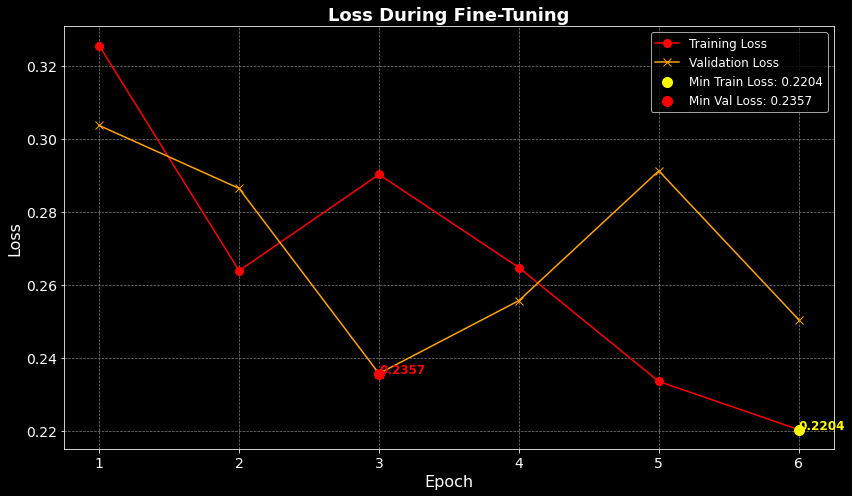

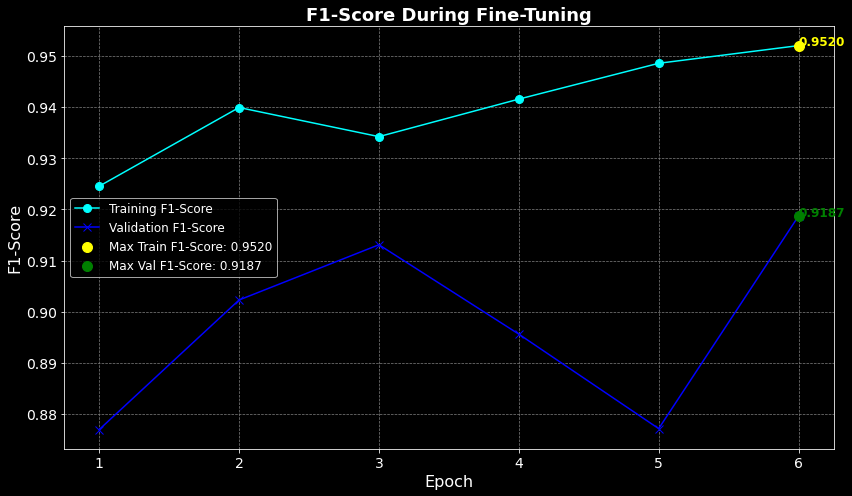

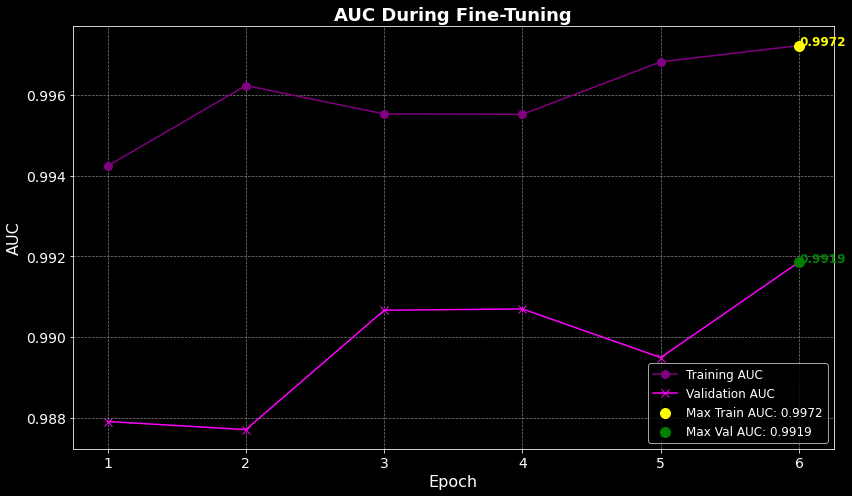

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the history object contains valid data
if not hasattr(fine_tune_history, 'history'):
    raise ValueError("The 'fine_tune_history' object must have a 'history' attribute.")

# Assuming `fine_tune_history` contains training and validation metrics
epochs = range(1, len(fine_tune_history.history['loss']) + 1)

# Define an advanced function to plot individual metrics
def plot_metric(metric_name, train_values, val_values, color_train, color_val, title):
    plt.figure(figsize=(12, 7))
    plt.style.use('dark_background')
    
    # Plot training and validation metrics
    plt.plot(epochs, train_values, color=color_train, marker='o', markersize=8, linestyle='-', label=f'Training {metric_name}', zorder=3)
    plt.plot(epochs, val_values, color=color_val, marker='x', markersize=8, linestyle='-', label=f'Validation {metric_name}', zorder=3)
    
    # Highlight min/max values for loss or max values for scores
    if metric_name.lower() == 'loss':
        min_train = min(train_values)
        min_train_epoch = np.argmin(train_values) + 1
        min_val = min(val_values)
        min_val_epoch = np.argmin(val_values) + 1
        plt.scatter(min_train_epoch, min_train, color='yellow', s=100, label=f'Min Train {metric_name}: {min_train:.4f}', zorder=5)
        plt.scatter(min_val_epoch, min_val, color='red', s=100, label=f'Min Val {metric_name}: {min_val:.4f}', zorder=5)
        plt.text(min_train_epoch, min_train, f'{min_train:.4f}', color='yellow', fontsize=12, fontweight='bold', zorder=6)
        plt.text(min_val_epoch, min_val, f'{min_val:.4f}', color='red', fontsize=12, fontweight='bold', zorder=6)
    else:  # For scores like F1, AUC
        max_train = max(train_values)
        max_train_epoch = np.argmax(train_values) + 1
        max_val = max(val_values)
        max_val_epoch = np.argmax(val_values) + 1
        plt.scatter(max_train_epoch, max_train, color='yellow', s=100, label=f'Max Train {metric_name}: {max_train:.4f}', zorder=5)
        plt.scatter(max_val_epoch, max_val, color='green', s=100, label=f'Max Val {metric_name}: {max_val:.4f}', zorder=5)
        plt.text(max_train_epoch, max_train, f'{max_train:.4f}', color='yellow', fontsize=12, fontweight='bold', zorder=6)
        plt.text(max_val_epoch, max_val, f'{max_val:.4f}', color='green', fontsize=12, fontweight='bold', zorder=6)
    
    # Customize plot
    plt.title(f'{title} During Fine-Tuning', fontsize=18, fontweight='bold')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel(metric_name, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.7, zorder=1)
    plt.tight_layout()
    plt.show()

# Plot Loss
plot_metric('Loss',
            fine_tune_history.history['loss'],
            fine_tune_history.history['val_loss'],
            color_train='red', color_val='orange',
            title='Loss')

# Plot F1-Score
plot_metric('F1-Score',
            fine_tune_history.history['F1-Score'],
            fine_tune_history.history['val_F1-Score'],
            color_train='cyan', color_val='blue',
            title='F1-Score')

# Plot AUC
plot_metric('AUC',
            fine_tune_history.history['AUC'],
            fine_tune_history.history['val_AUC'],
            color_train='purple', color_val='magenta',
            title='AUC')


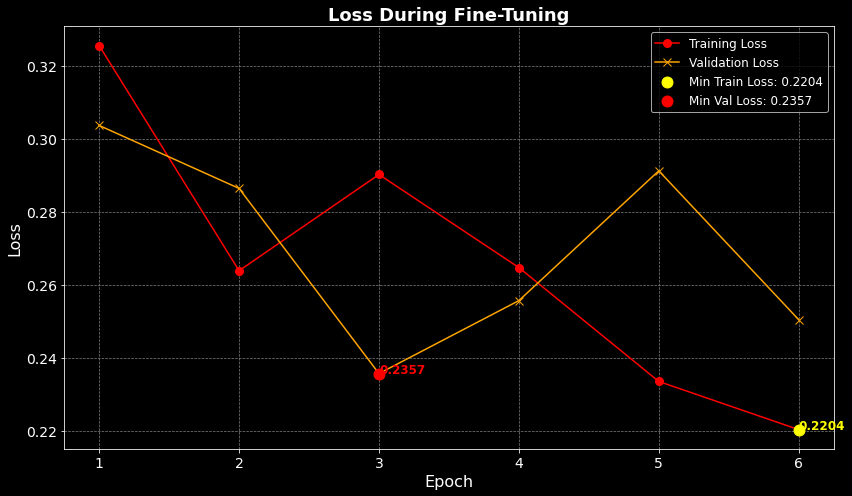

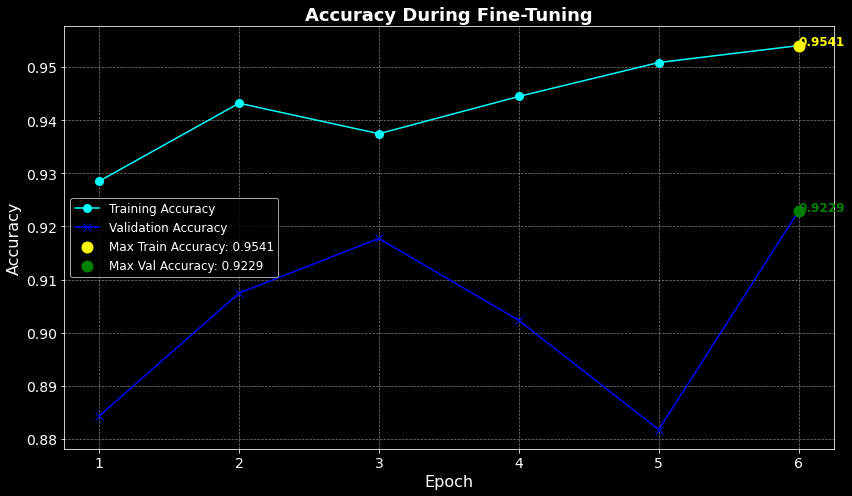

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the history object contains valid data
if not hasattr(fine_tune_history, 'history'):
    raise ValueError("The 'fine_tune_history' object must have a 'history' attribute.")

# Assuming `fine_tune_history` contains training and validation metrics
epochs = range(1, len(fine_tune_history.history['loss']) + 1)

# Define an advanced function to plot individual metrics
def plot_metric_advanced(metric_name, train_values, val_values, color_train, color_val, title):
    plt.figure(figsize=(12, 7))
    plt.style.use('dark_background')

    # Plot training and validation metrics
    plt.plot(epochs, train_values, color=color_train, marker='o', markersize=8, linestyle='-', label=f'Training {metric_name}', zorder=3)
    plt.plot(epochs, val_values, color=color_val, marker='x', markersize=8, linestyle='-', label=f'Validation {metric_name}', zorder=3)

    # Annotate key points (min loss, max accuracy)
    if metric_name.lower() == 'loss':
        # Minimize Loss
        min_train = min(train_values)
        min_train_epoch = np.argmin(train_values) + 1
        min_val = min(val_values)
        min_val_epoch = np.argmin(val_values) + 1
        plt.scatter(min_train_epoch, min_train, color='yellow', s=120, label=f'Min Train {metric_name}: {min_train:.4f}', zorder=5)
        plt.scatter(min_val_epoch, min_val, color='red', s=120, label=f'Min Val {metric_name}: {min_val:.4f}', zorder=5)
        plt.text(min_train_epoch, min_train, f'{min_train:.4f}', color='yellow', fontsize=12, fontweight='bold', zorder=6)
        plt.text(min_val_epoch, min_val, f'{min_val:.4f}', color='red', fontsize=12, fontweight='bold', zorder=6)
    else:  # For Accuracy
        # Maximize Accuracy
        max_train = max(train_values)
        max_train_epoch = np.argmax(train_values) + 1
        max_val = max(val_values)
        max_val_epoch = np.argmax(val_values) + 1
        plt.scatter(max_train_epoch, max_train, color='yellow', s=120, label=f'Max Train {metric_name}: {max_train:.4f}', zorder=5)
        plt.scatter(max_val_epoch, max_val, color='green', s=120, label=f'Max Val {metric_name}: {max_val:.4f}', zorder=5)
        plt.text(max_train_epoch, max_train, f'{max_train:.4f}', color='yellow', fontsize=12, fontweight='bold', zorder=6)
        plt.text(max_val_epoch, max_val, f'{max_val:.4f}', color='green', fontsize=12, fontweight='bold', zorder=6)

    # Customize plot
    plt.title(f'{title} During Fine-Tuning', fontsize=18, fontweight='bold')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel(metric_name, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.7, zorder=1)
    plt.tight_layout()
    plt.show()

# Plot Loss
plot_metric_advanced('Loss',
                     fine_tune_history.history['loss'],
                     fine_tune_history.history['val_loss'],
                     color_train='red', color_val='orange',
                     title='Loss')

# Plot Accuracy
plot_metric_advanced('Accuracy',
                     fine_tune_history.history['accuracy'],
                     fine_tune_history.history['val_accuracy'],
                     color_train='cyan', color_val='blue',
                     title='Accuracy')


In [58]:
c

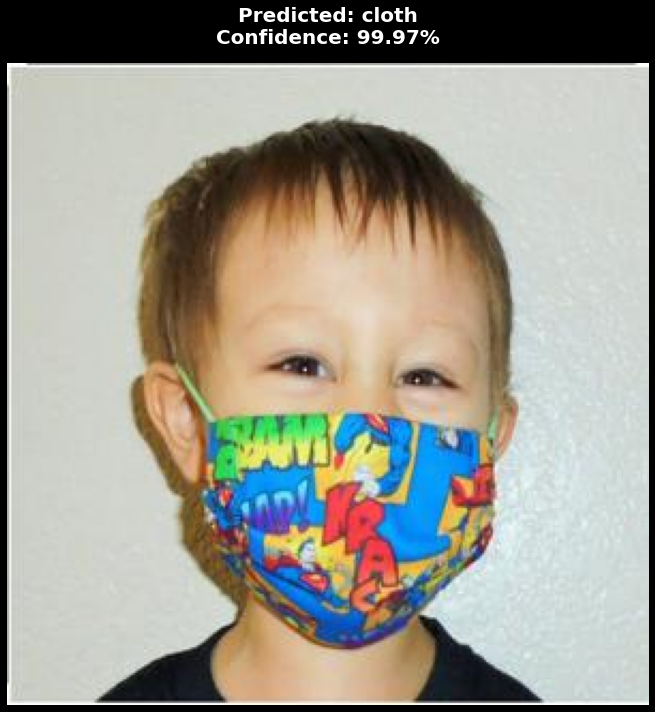

The given image is of:
Class: 0
Species: cloth
Confidence: 99.97%


In [60]:
# Example class names (adjust according to your model)
class_names = ['cloth', 'n95', 'n95v', 'nfm', 'srg']

# Usage example
predictor_img('/kaggle/input/face-mask-types-dataset/Dataset/test/cloth/411.jpg', model_fine, class_names)


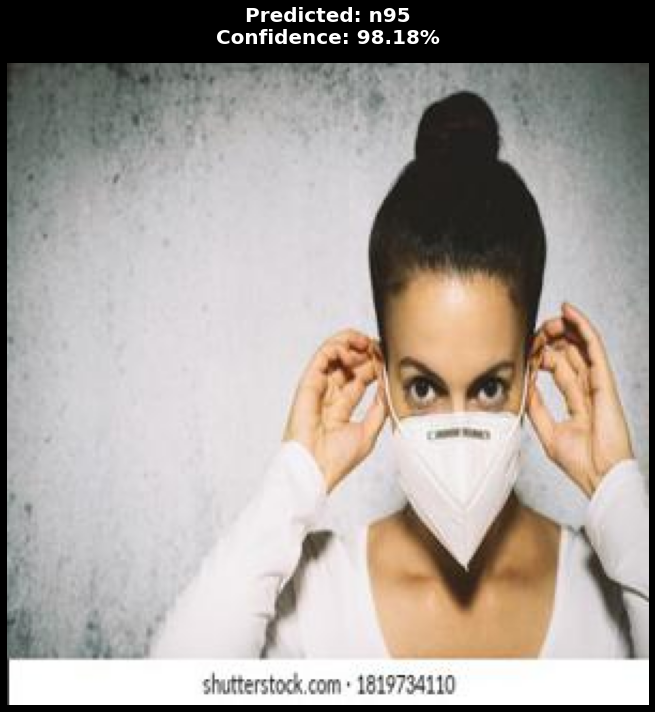

The given image is of:
Class: 1
Species: n95
Confidence: 98.18%


In [61]:
# Usage example
predictor_img('/kaggle/input/face-mask-types-dataset/Dataset/test/n95/372.jpg', model_fine, class_names)

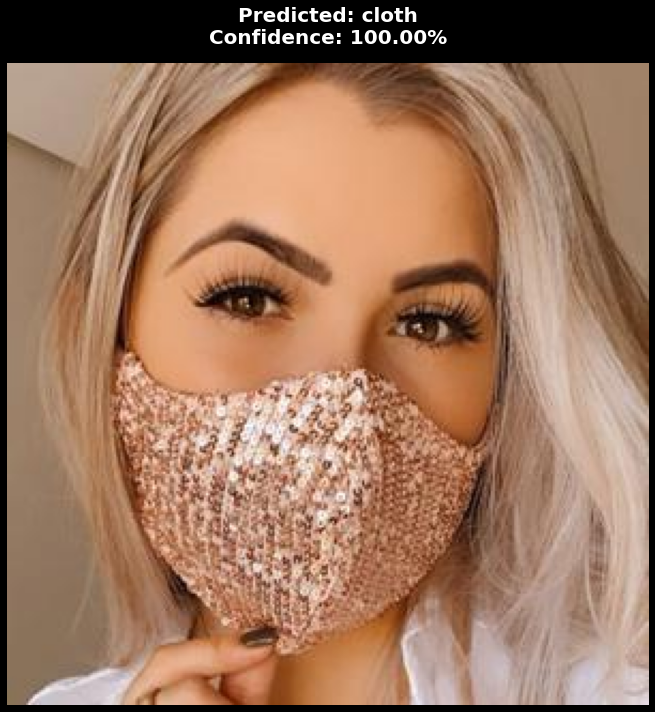

The given image is of:
Class: 0
Species: cloth
Confidence: 100.00%


In [62]:
# Usage example
predictor_img('/kaggle/input/face-mask-types-dataset/Dataset/test/cloth/399.jpg', model_fine, class_names)

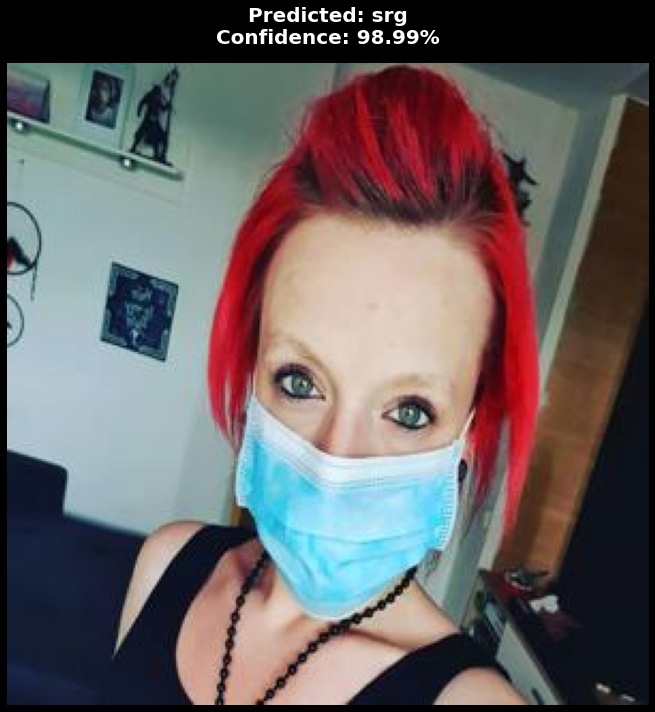

The given image is of:
Class: 4
Species: srg
Confidence: 98.99%


In [63]:
# Usage example
predictor_img('/kaggle/input/face-mask-types-dataset/Dataset/test/srg/356.jpg', model_fine, class_names)

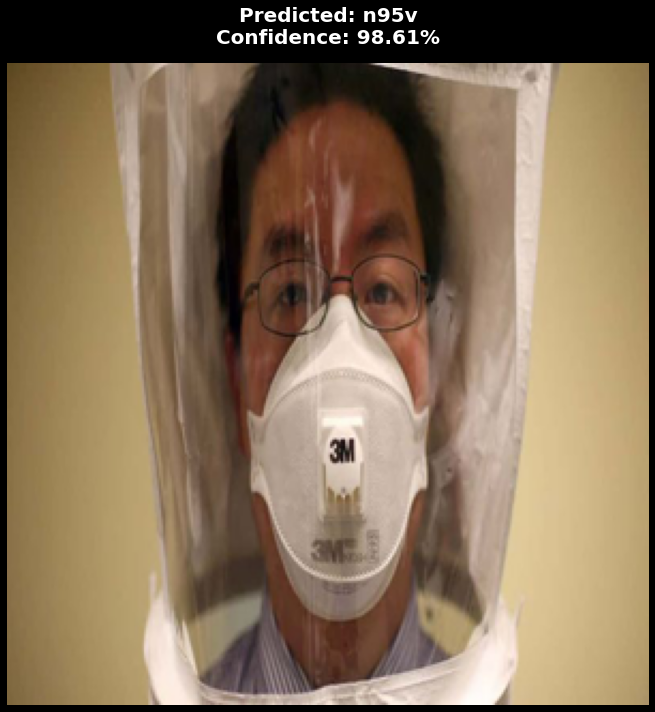

The given image is of:
Class: 2
Species: n95v
Confidence: 98.61%


In [64]:
# Usage example
predictor_img('/kaggle/input/face-mask-types-dataset/Dataset/test/n95v/410.png', model_fine, class_names)